# Gold Prediction ARIMA-GARCH semi model

Franck Bui Nguyen

email : franck5nguyen@gmail.com

The purpose of this paper is to: 

1) understand the different variable that can affect the gold spot price and the interraction with all other asset classes from commodities to equities and forex

2) Forecast gold spot price on a short term (about 1 month in the future) using several paper research 
* https://www.researchgate.net/publication/324273329_Trading_gold_future_with_ARIMA-GARCH_model

Note : Main languages used are Python, C++ and some R

# Summary
* Correlation studies
* Forecasting using ARIMA(P,D,Q)
* Presentation GARCH(P,Q)
* Forecasting using hybrid ARIMA-GARCH model

## ARIMA Model

$X_t - \alpha_{1} X_{t-1}-...- \alpha_p X_{t-p} = \epsilon_{t} + \theta_1 \epsilon_{t-1} + .... + \theta_q \epsilon_{t-q}$ 

## GARCH Model
Problem with variance, we are using GARCH model to modelise the 2nd moment of a time series

$\sigma^2_t = \alpha_0 + \alpha_1 \epsilon^2_1 + ... + \alpha_q \epsilon^2_{t-q} = \alpha_0 + \sum_{i=1}^q \alpha_i \epsilon_{t-i}^2$

In [17]:
import dataMngt as dtmgt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsParam as stsp
from statsmodels.tsa.seasonal import  seasonal_decompose

In [18]:
#get gold data from 2006 till now
all = pd.read_csv(r'C:\Coding\Python Project\Stocks\Data\stock.csv',index_col=False)
EQD = all.loc[all.type == 'EQD']
CTY = all.loc[all.type == 'CTY']
FX = all.loc[all.type == 'FX']

#Format table
allFormat = dtmgt.unstackData(all)
EQDFormat = dtmgt.unstackData(EQD,typeList = ['EQD'])
CTYFormat = dtmgt.unstackData(CTY,typeList = ['CTY'])
FXFormat = dtmgt.unstackData(FX,typeList = ['FX'])

## Correlation 

First lets get an overall look of what the gold spot price looks like from 1st of January 2005 until now

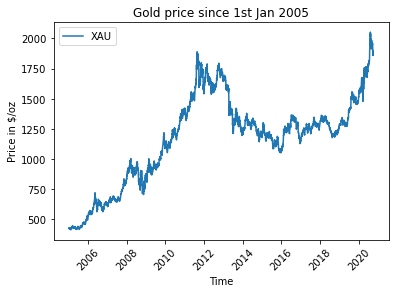

In [19]:
xau = allFormat[['XAU']] #Gold price

sns.lineplot(data=xau)
plt.title("Gold price since 1st Jan 2005")
plt.xlabel('Time')
plt.ylabel('Price in $/oz')
plt.xticks(rotation=45);

# Coronavirus 
The coronavirus hitted financial market around early April 2020 as we can clearly see the deep. During the following month, gold has seen an un-precedented bullish market.

The first reason is that during time of uncertainty, investissors wish to hedge themselves against various factors, for example the power of a money can severely decrease if a country is heated severely by the crisis or hedging against potential volatil underlying asset.

One way to do so is to invest in safe heavens and for ages, gold has proven to be safe and especially in emerging countries.

[]

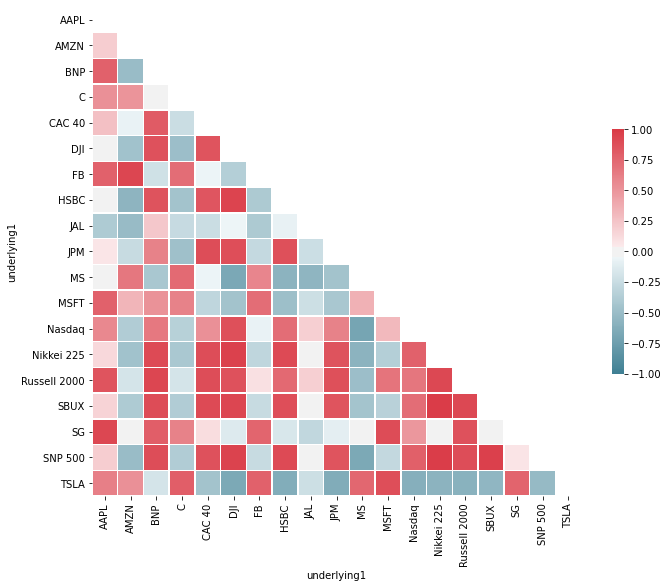

In [20]:
#Calculate correlation between each asset
corrAll, maskALL = stsp.corrParam(allFormat)
corrEQD, maskEQD = stsp.corrParam(EQDFormat)
corrCTY, maskCTY = stsp.corrParam(CTYFormat)
corrFX, maskFX = stsp.corrParam(FXFormat)

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
stsp.corrPlot(corrEQD,maskEQD)

plt.plot()

30/09/2020


# ARIMA(P,D,Q) Model

But is gold stationary? 

Let $X_t$ be a time series with $t$ the time I am looking at and $X_t$ it's value.
$X_t = S_t + \epsilon$

--

*Def : Stationarity*

**Weak**

A time series is defined in its weak form if the time series is independant from time at each instant it is observed.


**Strong**

The density law of $X_t$ at a time t is the same if look at $X_{t+\epsilon}$

then $$\forall t \in [0,T], \forall \epsilon > 0$$
$X_t$ is stationary if $\mathcal{L}(X_t) = \mathcal{L}(X_{t+\epsilon}), \forall \epsilon$

--

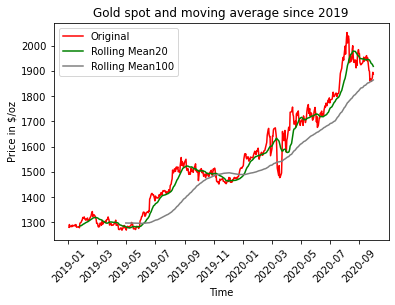

In [21]:
xau = xau[xau.index>="2019-01-01"].dropna() # Filter for 2020 only
rolling_mean20 = xau.XAU.rolling(20).mean()
rolling_mean100 = xau.XAU.rolling(100).mean()

plt.plot(xau, color = 'red', label = 'Original')
plt.plot(rolling_mean20, color = 'green', label = 'Rolling Mean20')
plt.plot(rolling_mean100, color = 'grey', label = 'Rolling Mean100')

plt.legend(loc = 'best')
plt.title('Gold spot and moving average since 2019')
plt.xlabel('Time')
plt.ylabel('Price in $/oz')
plt.xticks(rotation=45);

Lets break down the time series into its different component 

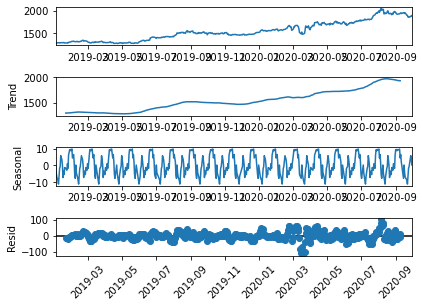

In [22]:
xauDecomposition = seasonal_decompose(xau, period=30)
xauTrend = xauDecomposition.trend
xauSeasonal = xauDecomposition.seasonal
xauResidual = xauDecomposition.resid

xauDecomposition.plot()
plt.xticks(rotation=45);

The first figure represents the origial price, the second figure represents the trend of price, the third figure represents its seasonality and the last one represents it's residual.

Without using any mathematics, we can clearly see a tendency throughout time, that is overall the price has been increasing over the months. Moreover if we look closely, both moving average prove that the rolling mean 20 days and 100 days keep growing. I can first sniff out that this time series might not be a stationary one.

Lets prove it mathematically with a statistics test

--

H0 : Null hypothesis, the time series is not stationary (residual depends from themselves)

H1 : Hypothesis 1, the time series is stationary, independant from himself.

--

Looking at Critical value, 
Test stats < CV10 < CV5 < CV1 < pValue
    On est sur a 99% que la serie est stationnaire
pValue = Proba H0 will not be rejected, si grand : on ne rejete pas donc stationnaire sinon on rejete


In [23]:
stsp.stationary_test(xau)

Results of Dickey-Fuller Test:
Test Statistic                  -0.219530
p-value                          0.936153
No. Lags Used                   10.000000
Number of Observations Used    510.000000
Critical value (1%)             -3.443237
Critical value (5%)             -2.867224
Critical value (10%)            -2.569797
dtype: float64


From the above result, I have a huge p-value which means that the probability to reject H0 wrongely is high. I thus take H0 meaning that the time series is **not stationary**. This is what we have already proved just by looking at it but I now prove it mathematicaly.

## Integrated(D)

One way to transform a non stationary time series into a stationary one is by differencing

Let $\bar{X_t}$ be the transformed time series,

By using the following transform,
$$\bar{X_t} = X_t - X_{t-1}$$

02/10/2020

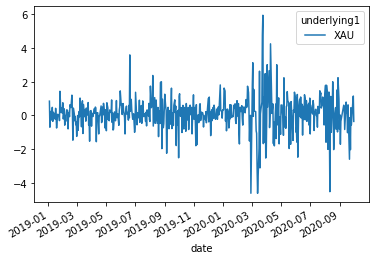

In [24]:
xauDiff = np.log(xau).dropna()
result = xau.pct_change().dropna()*100
result.plot();